# Evaluation
- compare verb/nouns 
- look at frequency of repeated words
- number of stop words
- free form prompts for empirical evaluation
- look for common beatles themes (heartbreak, girl, dancing,)
- syllable counts

In [3]:
# !pip install transformers
# !pip install torch
# !pip install stop_words

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt 
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline
import statistics
from nltk.translate.bleu_score import sentence_bleu
import nltk
from nltk.corpus import stopwords
# from stop_words import get_stop_words
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

In [4]:
def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model

def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer

def generate_text(sequence, max_length, temp):
    model_path = "results_report"
    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95, temperature=temp
    )
    return(tokenizer.decode(final_outputs[0], skip_special_tokens=True))

In [5]:
naive_model = pipeline('text-generation', model='gpt2-medium')
naive_model("Hello, I'm a language model,", max_length=30, num_return_sequences=1)[0]['generated_text']


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Hello, I'm a language model, not a runtime model!\n\nWe've come to learn to understand how a language works by understanding why languages"

In [6]:
test = pd.read_parquet('testing_lyrics.parquet').reset_index(drop=True)
test.head()

,lyrics
0,"Don't let me down, don't let me down Don't let..."
1,I get high when I see you go by My oh my When ...
2,[All too much!] It's all too much It's all to...
3,"I love you, 'cause you tell me things I want t..."
4,Is there anybody going to listen to my story A...


In [17]:
# test['input'] = test['lyrics'].apply(lambda x: ' '.join(x.split()[:50])) # 50 tokens
# test['tuned_prediction'] = test['input'].apply(lambda input_text: generate_text(input_text ,200, temp=.7)) # 200 tokens
# test['naive_prediction'] = test['input'].apply(lambda input_text: naive_model(input_text, max_length=200, num_return_sequences=1)[0]['generated_text'])
# test.to_parquet('predictions.parquet')

In [18]:
preds = pd.read_parquet('predictions.parquet')
preds['lyrics_end'] = preds['lyrics'].apply(lambda x: ' '.join(x.split()[50:150])) # 100 tokens
preds['naive_prediction_end'] = preds['naive_prediction'].apply(lambda x: ' '.join(x.split()[50:150])) # 100 tokens
preds['tuned_prediction_end'] = preds['tuned_prediction'].apply(lambda x: ' '.join(x.split()[50:150])) # 100 tokens
preds.head()

,lyrics,input,naive_prediction,tuned_prediction,lyrics_end,naive_prediction_end,tuned_prediction_end
0,"Don't let me down, don't let me down Don't let...","Don't let me down, don't let me down Don't let...","Don't let me down, don't let me down Don't let...","Don't let me down, don't let me down Don't let...","let me down Don't let me down, don't let me do...",let me down I love you (more and louder) I lov...,"let me down Don't let me down, don't let me do..."
1,I get high when I see you go by My oh my When ...,I get high when I see you go by My oh my When ...,I get high when I see you go by My oh my When ...,I get high when I see you go by My oh my When ...,is all But it's so hard loving you Is it right...,all I can do Why is there not more love in you...,is all But it's so hard loving you Is it right...
2,[All too much!] It's all too much It's all to...,[All too much!] It's all too much It's all too...,[All too much!] It's all too much It's all too...,[All too much!] It's all too much It's all too...,"Everywhere, it's what you make For us to take,...",seems to be gone forever Now I'm just another ...,"Everywhere, it's what you make For us to take,..."
3,"I love you, 'cause you tell me things I want t...","I love you, 'cause you tell me things I want t...","I love you, 'cause you tell me things I want t...","I love you, 'cause you tell me things I want t...","the reason why If I cry, it's not because I'm ...",And never ever forget that I'm my own mother O...,"I Would love to love you And to hold you, to l..."
4,Is there anybody going to listen to my story A...,Is there anybody going to listen to my story A...,Is there anybody going to listen to my story A...,Is there anybody going to listen to my story A...,so hard to leave her She will turn to me and s...,"to forget. Ah, girl when I think of all the ti...",so hard to leave her She will turn to me and s...


## BLEU Score

In [20]:
i = 10
print(preds['input'][i],'\n')
print(preds['lyrics_end'][i],'\n')
print(preds['naive_prediction_end'][i],'\n')
print(preds['tuned_prediction_end'][i])

I'm looking through you, where did you go? I thought I knew you, what did I know? You don't look different, but you have changed I'm looking through you, you're not the same Your lips are moving, I cannot hear Your voice is soothing, but the words aren't clear You 

don't sound different, I've learned the game I'm looking through you, you're not the same Why, tell me why, did you not treat me right? Love has a nasty habit of disappearing overnight You're thinking of me, the same old way You were above me, but not today The only difference is you're down there I'm looking through you, and you're nowhere Why, tell me why, did you not treat me right? Love has a nasty habit of disappearing overnight I'm looking through you, where did you go I thought I knew you, what did I know You don't look 

are not smiling and I don't think I can see Your lips are moving, I cannot hear My ears hear whispers, I cannot find you You, your eyes are bright and shining, the sound echoes, You are not the same

In [19]:
def tokenize(string):
    return(string.lower().replace(',','').replace('(','').replace(')','').replace("?",'').split(' '))

In [20]:
scores=[]
for i in range(len(preds)):
    reference = [tokenize(preds['lyrics_end'][i])]
    candidate = tokenize(preds['prediction_end'][i])
    scores.append((i,sentence_bleu(reference, candidate)))

scores

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


[(0, 0.2897712227359836),
 (1, 0.646375296523063),
 (2, 0.23402930214913525),
 (3, 0.3752997659565948),
 (4, 0.20700349754928846),
 (5, 0.7712891710003998),
 (6, 0.5057273040147398),
 (7, 0.09564326415242994),
 (8, 0.42360702654533455),
 (9, 0.4759008404227064),
 (10, 0.9898464007679532),
 (11, 0.2047433805375264),
 (12, 0.42116538580137375),
 (13, 0.1512723047121723),
 (14, 0.23144294603400217),
 (15, 0.6058411988967459),
 (16, 0.2906926607808719),
 (17, 0.6722418959687326),
 (18, 0.7480215085762352),
 (19, 0.1641934295933072),
 (20, 0.6731466875872781),
 (21, 2.9429726889060215e-155),
 (22, 0.36221828372658416),
 (23, 0.5342088306247204),
 (24, 3.0365165142715324e-155),
 (25, 0.6586660362825382),
 (26, 0.12467238394823492),
 (27, 0.2632676481282301),
 (28, 0.08642344511992131),
 (29, 0.6668295025207619),
 (30, 2.6592760182644606e-155),
 (31, 0.6565415167594035),
 (32, 0.19856505956263457),
 (33, 0.36166204890743703)]

In [21]:
just_scores=[]
total =0
[just_scores.append(score) for i, score in scores]
for num in just_scores:
    total+=num
total/len(just_scores)

0.38500909546724543

## Parts of Speech

In [22]:
preds[['input', 'lyrics_end', 'prediction_end']].head()

,input,lyrics_end,prediction_end
0,"Don't let me down, don't let me down Don't let...","let me down Don't let me down, don't let me do...","let me down Don't let me down, don't let me do..."
1,I get high when I see you go by My oh my When ...,is all But it's so hard loving you Is it right...,is all But it's so hard loving you Is it right...
2,[All too much!] It's all too much It's all too...,"Everywhere, it's what you make For us to take,...","Everywhere, it's what you make For us to take,..."
3,"I love you, 'cause you tell me things I want t...","the reason why If I cry, it's not because I'm ...","The things you say like that I love you, 'caus..."
4,Is there anybody going to listen to my story A...,so hard to leave her She will turn to me and s...,so hard to leave her She will turn to me and s...


In [23]:
all_preds_str = ' '.join(list(preds.prediction_end.str.lower()))
all_actual_str = ' '.join(list(preds.lyrics_end.str.lower()))


In [24]:
tokens = tokenize(all_actual_str)
pos = nltk.pos_tag(tokens)
actual_counts={}
for word, tag in pos:
    if tag in actual_counts:
        actual_counts[tag]+=1
    else:
        actual_counts[tag]=1

tokens = tokenize(all_preds_str)
pos = nltk.pos_tag(tokens)
pred_counts={}
for word, tag in pos:
    if tag in pred_counts:
        pred_counts[tag]+=1
    else:
        pred_counts[tag]=1


In [25]:
pos_dist = pd.concat([pd.Series(actual_counts),pd.Series(pred_counts)],axis=1).rename(columns={0:'actual', 1:'prediction'}).sort_values('actual',ascending=False)
pos_dist

,actual,prediction
NN,653,692.0
VB,300,310.0
PRP,293,318.0
JJ,273,252.0
IN,245,282.0
VBP,244,218.0
RB,230,218.0
DT,209,244.0
PRP$,115,118.0
CC,110,110.0


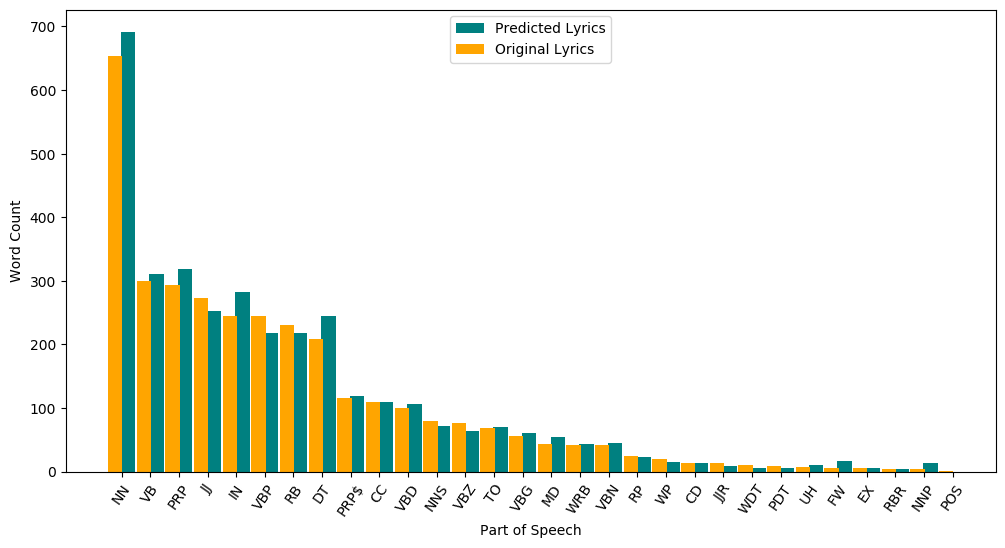

In [26]:
ind = np.arange(len(pos_dist))  # the x locations for the groups
width = .45
plt.figure(figsize=[12,6])
plt.bar(ind+width, pos_dist.prediction, .5, label='Predicted Lyrics', color='teal')
plt.bar(ind, pos_dist.actual, .5, label='Original Lyrics', color='orange')
plt.xticks(rotation=55)
plt.legend()
plt.xlabel('Part of Speech')
plt.ylabel('Word Count')
plt.xticks(ind + width / 2, (pos_dist.index),rotation=55)
plt.show()

## Count Frequency

In [29]:
nltk_stop_words = list(stopwords.words('english'))
stop_words = list(get_stop_words('en'))
stop_words.extend(nltk_stop_words)

all_actual_str_no_stop = [w for w in tokenize(all_actual_str) if not w in stop_words]
all_preds_str_no_stop = [w for w in tokenize(all_preds_str) if not w in stop_words]


In [30]:
tokenize(all_actual_str)[:10]

['let', 'me', 'down', "don't", 'let', 'me', 'down', "don't", 'let', 'me']

In [31]:
all_actual_str_no_stop[:10]

['let', 'let', 'let', 'love', 'first', 'time', 'know', 'gonna', 'last', 'love']

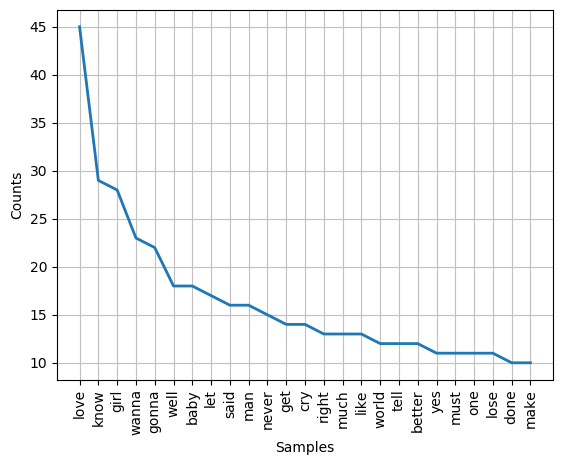

In [32]:
data_analysis = nltk.FreqDist(all_actual_str_no_stop)
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 2])
data_analysis = nltk.FreqDist(filter_words)
data_analysis.plot(25, cumulative=False);
plt.title('Frequent Words in Original Lyrics');


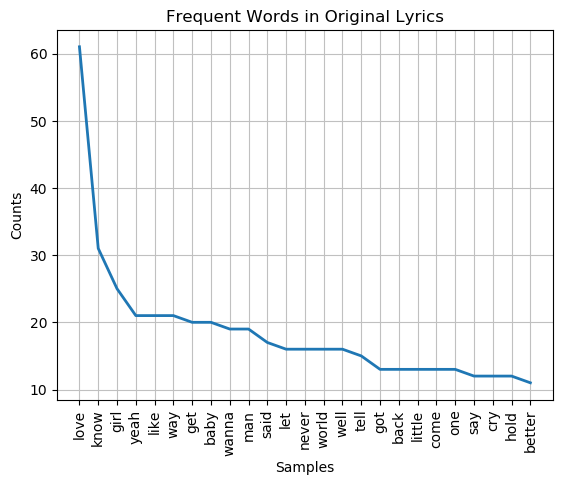

In [33]:
data_analysis = nltk.FreqDist(all_preds_str_no_stop)
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 2])
data_analysis = nltk.FreqDist(filter_words)
data_analysis.plot(25, cumulative=False);
plt.title('Frequent Words in Generated Lyrics');

## Free Text Generation

In [34]:
def generate_text(sequence, max_length, temp):
    model_path = "results_old"
    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95, temperature=temp
    )
    return(tokenizer.decode(final_outputs[0], skip_special_tokens=True))

In [42]:
output = generate_text("I am going", 100, temp=.5)
output

"I am going to find her, oh I know where she's been Misunderstanding the situation Taking the easy way out For she would never be free When I was around Ah I'm looking through you, where did you go? I thought I knew you, what did I know? You don't look different, but you have changed I'm looking through you, you're not the same Your lips are moving, I cannot hear Your voice is soothing, but the words aren't clear You don't"

In [43]:
output = generate_text("I am going", 100, temp=1.2)
print(output)

I am going to love you more Every day I get to the bottom of this I can't believe it's happened to me I can't conceive of any more misery Ask me why, I'll say I love you And I'm always thinking of you I can't conceive of any more misery Ask me why, I'll say I love you And I'm always thinking of you Oh darling, you are so young and beautiful And you'll be able to see me standing there I'm certain that I will


In [44]:
output = generate_text("I am going", 100, temp=1.7)
print(output)

I am going to London to see my brother. Can you take me, brother?】 Yes You may be a lover but you ain't no dancer Look out helter skelter helter skelter Helter skelter ooh Look out helter skelter for the glimmer of hope Shine bright, come off your high horse Here comes the Sun King Here comes the Sun King to show his love for you Sexy Sadie what you can do When you're under the stars Looking


In [45]:
output = generate_text("I am going", 100, temp=3.0)
print(output)

I am going] The party has left town She said "I cannot invite you here again Let me look around Until I find a nice obed sister With a glass neck and sharp dressed white hair She's the latest specimen my dad got sent to me," crying BibimbofundityNobly locatedHumboldt rescue dug his graveNo one reported The rumoured disease was triflingThird sighting is the news I've been anxiously waitingfor Sit back and have the tour roll pleaseTrey
